<a href="https://colab.research.google.com/github/RazorPG/classification-website-phising/blob/main/phising_website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_community
!pip install replicate

In [ ]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata

#set the API token
api_token = userdata.get('api_token')
os.environ['REPLICATE_API_TOKEN'] = api_token

# model setup
model = 'ibm-granite/granite-3.3-8b-instruct'
output = Replicate(
    model=model,
    replicate_api_token=api_token,
)


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "phishing.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "eswarchandt/phishing-website-detector",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/tmp/ipython-input-4015495891.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [ ]:
# menghilangkan kolom Index dan pisahkan fitur vs label
df = df.drop(columns=['Index'])
X = df.drop(columns=['class']) # fitur
y = df['class'] # label asli (-1: legit, 1: phishing)

In [ ]:
def feature_to_prompt(row):
    prompt = "Given the following website characteristics:\n"
    for col in X.columns:
        val = row[col]
        if val == 1:
            desc = "Yes"
        elif val == -1:
            desc = "No"
        else:
            desc = "Suspicious"
        prompt += f"- {col}: {desc}\n"
    prompt += "Is this website phishing or legitimate? Explain."
    return prompt

In [ ]:
results = []
n = 30  # jumlah sampel untuk kirim ke Granite

for i in range(n):
    prompt = feature_to_prompt(X.iloc[i])
    try:
        response = output.invoke(prompt)
    except Exception as e:
        response = f"[ERROR] {e}"
    results.append({
        "id": i,
        "true_label": "Phishing" if y.iloc[i] == 1 else "Legitimate",
        "granite_response": response
    })

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)  # biar respon tidak terpotong
results_df

,id,true_label,granite_response
0,0,Legitimate,"Based on the given characteristics, this website exhibits several red flags that suggest it might be a phishing site. Here's a breakdown:\n\n1. **UsingIP**: Yes - Phishing sites often use IP addresses instead of domain names to avoid detection by some security tools.\n\n2. **LongURL & ShortURL**: Yes - Both can be used to obfuscate the actual destination, a common tactic in phishing to deceive users.\n\n3. **Symbol@**: Yes - The use of '@' symbol in URLs can be indicative of an attempt to mislead users, as it's not a standard character in URLs.\n\n4. **Redirecting//**: Yes - Frequent redirection, especially through double slashes, can be a sign of phishing attempts to confuse users or bypass security measures.\n\n5. **SubDomains**: Suspicious - Phishing sites often use subdomains to mimic legitimate sites or to avoid direct scrutiny.\n\n6. **HTTPS**: Yes - While HTTPS is a good sign in general, it's also used by phishing sites to create a false sense of security.\n\n7. **NonStdPort**: Yes - Using non-standard ports can be a tactic to hide malicious activities.\n\n8. **IframeRedirection**: Yes - This technique is often used in phishing to load content from another site without the user's knowledge.\n\n9. **AnchorURL**: Suspicious - Unusual or misleading anchor text in links is a common phishing tactic.\n\n10. **WebsiteForwarding**: Suspicious - If this site forwards users to other sites without clear indication, it could be part of a phishing scheme.\n\n11. **StatusBarCust**: Yes - Customizing the browser's status bar can hide the true URL, a tactic used by phishers.\n\n12. **DisableRightClick**: Yes - Disabling the right-click context menu is a common technique to prevent users from inspecting or copying URLs.\n\n13. **UsingPopupWindow**: Yes - Phishing sites may use pop-ups to distract users or to prompt for sensitive information.\n\n14. **InfoEmail**: Yes - Requesting personal information via email is a classic phishing method.\n\n15. **AbnormalURL**: Yes - URLs that don't conform to"
1,1,Legitimate,"Based on the provided characteristics, this website exhibits several suspicious traits that are often associated with phishing attempts. Here's a breakdown of the red flags:\n\n1. **UsingIP**: Yes - Direct IP usage can be a tactic to avoid detection by some security tools.\n2. **LongURL**: Suspicious - While a long URL isn't inherently malicious, it can be used to obfuscate the actual destination.\n3. **ShortURL**: Yes - Shortened URLs can mask the true destination, which might be a phishing site.\n4. **Symbol@**: Yes - The use of '@' symbol in the URL can be misleading, as it might suggest an email address.\n5. **Redirecting//**: Yes - Excessive or unexpected redirections are common in phishing sites to confuse users and bypass security checks.\n6. **SubDomains**: No - The absence of subdomains might indicate a simpler, potentially less-monitored domain structure.\n7. **HTTPS**: No - Lack of HTTPS indicates no encryption, making it easier for attackers to intercept data.\n8. **NonStdPort**: Yes - Using non-standard ports (not the usual 80 for HTTP or 443 for HTTPS) can be an attempt to hide the true nature of the site.\n9. **Redirecting//**: Yes - Multiple redirects can confuse users and security tools.\n10. **Symbol@**: Yes - '@' symbol in URL might suggest an email address, attempting to deceive users.\n11. **UsingPopupWindow**: Yes - Unwanted pop-ups are a common tactic to distract users or force them to click on malicious content.\n12. **IframeRedirection**: Yes - Using iframes for redirection can help hide the actual URL being visited.\n13. **AgeofDomain**: Yes - While domain age alone doesn't determine maliciousness, new domains can be used for phishing as they're less likely to be blacklisted.\n14. **StatusBarCust**: Yes - Customizing the status bar might be used to hide information or mislead users about the site's nature.\n15. **DisableRightClick**: Yes - Disabling right-

In [ ]:
# Simple heuristik: jika kata 'phishing' muncul → prediksi phishing
def granite_to_pred(resp):
    resp = resp.lower()
    if "phishing" in resp:
        return "Phishing"
    elif "legitimate" in resp:
        return "Legitimate"
    else:
        return "Unclear"

results_df["granite_pred"] = results_df["granite_response"].apply(granite_to_pred)

# Bandingkan prediksi vs label
results_df["correct"] = results_df["true_label"] == results_df["granite_pred"]
accuracy = results_df["correct"].mean()
print(f"Akurasi prediksi Granite (heuristik): {accuracy:.2%}")


Akurasi prediksi Granite (heuristik): 40.00%


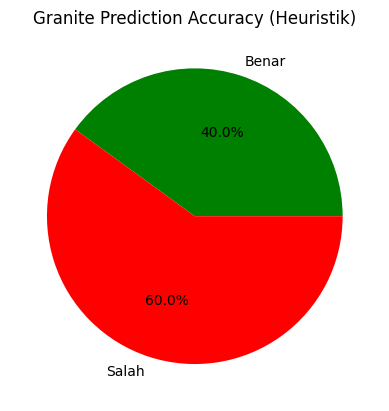

In [ ]:
import matplotlib.pyplot as plt

# Pie chart akurasi
labels = ['Benar', 'Salah']
sizes = [results_df['correct'].sum(), (~results_df['correct']).sum()]
colors = ['green', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Granite Prediction Accuracy (Heuristik)')
plt.show()
